# Projeto Machine Leaning

## Introdução ao projeto

### Sobre o problema

Como o mercado de trabalho cada vez mais acirrado em busca de bons profissionais,

a ideia do projeto é prever a rotatividade de funcionários, 

analisando possiveis causas, 

buscando insights para a gestão de pessoas (RH), reduzir a rotatividade.

### Sobre a base de dados

A base de dados contém uma lista de quase 15 mil funcionarios, dos mais diversos setores da empresa.

Categorizada com as informações de 
- departamento, 
- faixa salarial (baixo, médio, alto), 
- média de horas trabalhadas mensal dos últimos 3 meses,
- número de projetos,
- tempo de empresa em anos,
- nota de avaliação (0-100),
- nota de satisfação (0-100),
- se teve acidente de trabalho (0/1),
- se saiu da empresa (0/1)

#### Sobre os métodos de classificação escolhidos

Por se tratar de um problema de classificação decidi avaliar os seguintes métodos para o projeto:


**Decision Tree Classifier**
é uma representação simples para classificação

**Random Forest Classifier** 
é uma representação de multiplas árvores aleatórias em conjunto

**Gradient Boosting Classifier**
é um grupo de algoritmos de machine learning fracos combinados para criar um modelo mais reforçado

**Light Gradient Boosting Machine Classifier**
é um grupo de algoritmos de reforço de gradiente estocástico


## Importando as dependencias do projeto e carregando o dataset

In [1674]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Importando métodos de métrica de avaliação
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix



from sklearn import set_config
set_config(print_changed_only=False)

In [1675]:
df = pd.read_csv('dataset_base.csv')

In [1676]:
df = df[['department', 'salary', 'mean_work_last_3_months',
          'number_projects', 'satisfaction_level', 'last_evaluation',
          'time_in_company', 'work_accident','left']]

df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


### Limpeza de registros nulos ou invalidos

In [1677]:
df.isnull().sum()

department                 0
salary                     0
mean_work_last_3_months    0
number_projects            0
satisfaction_level         0
last_evaluation            0
time_in_company            0
work_accident              0
left                       0
dtype: int64

### Alterando os tipo dos registros

In [1678]:
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 761.8+ KB


### Renomeando os atributos

In [1679]:
df = df.rename(columns={
                        'department': 'departamento',
                        'salary': 'salario',
                        'satisfaction_level': 'satisfacao', 
                        'last_evaluation': 'avaliacao',
                        'number_projects': 'num_projetos',
                        'mean_work_last_3_months': 'media_horas_mensais',
                        'time_in_company': 'tempo_empresa',
                        'work_accident': 'acidente_trabalho',
                        'left' : 'rotatividade',
                        })

df.head()

,departamento,salario,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


## Iniciando a analise estatística

### Visão estatistica dos dados

In [1680]:
df.shape

(14999, 9)

In [1681]:
df.describe()

,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,275.685579,3.803054,61.283352,71.610174,3.498233,0.144610,0.238083
std,10.054675,1.232592,24.863065,17.116911,1.460136,0.351719,0.425924
min,232.000000,2.000000,9.000000,36.000000,2.000000,0.000000,0.000000
25%,269.000000,3.000000,44.000000,56.000000,3.000000,0.000000,0.000000
50%,276.000000,4.000000,64.000000,72.000000,3.000000,0.000000,0.000000
75%,282.000000,5.000000,82.000000,87.000000,4.000000,0.000000,0.000000
max,321.000000,7.000000,100.000000,100.000000,10.000000,1.000000,1.000000


### Calculando a taxa de rotatividade

In [1682]:
turnover_rate = df.rotatividade.value_counts() / len(df)

turnover_rate

0    0.761917
1    0.238083
Name: rotatividade, dtype: float64

In [1683]:
turnover_summary = df.groupby('rotatividade')
turnover_summary.mean()

,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho
rotatividade,,,,,,
0,275.734687,3.79349,64.330942,71.582079,3.382394,0.160396
1,275.528423,3.83366,51.530384,71.700084,3.868944,0.094091


O conjunto de dados tem:

- 14.998 observações de empregados e 9 atributos.
- A empresa tem uma rotatividade de 24%. (0.238083)
- A satisfação média dos empregados é de 61. (61.283352)
- A satisfação média dos empregados que deixaram a empresa é 51. (51.530384)

### Analisando correlações

,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
media_horas_mensais,1.000000,-0.009790,0.007669,-0.007087,0.004822,0.011991,-0.008737
num_projetos,-0.009790,1.000000,-0.142970,0.349333,0.196786,-0.004741,0.013881
satisfacao,0.007669,-0.142970,1.000000,0.105021,-0.100866,0.058697,-0.219284
avaliacao,-0.007087,0.349333,0.105021,1.000000,0.131591,-0.007104,0.002936
tempo_empresa,0.004822,0.196786,-0.100866,0.131591,1.000000,0.002120,0.141927
acidente_trabalho,0.011991,-0.004741,0.058697,-0.007104,0.002120,1.000000,-0.080293
rotatividade,-0.008737,0.013881,-0.219284,0.002936,0.141927,-0.080293,1.000000


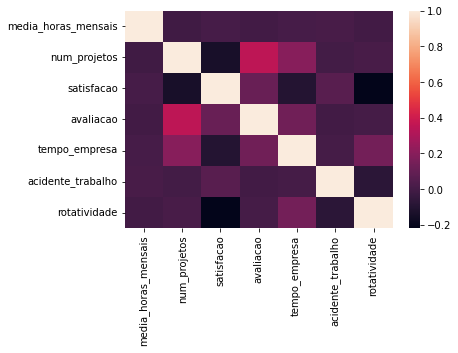

In [1684]:
corr = df.corr()
corr = (corr)
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)
corr

**Atributos com uma correlação moderada positiva:** 
- número de projetos vs avaliação: 0.34
- tempo de empresa vs número de projetos: 0.19

**Atributos com uma correlação moderada negativa:**
 - satisfação vs rotatividade:  -0.21

**Questões:**
- Quais atributos afetam nossa variável alvo (rotatividade)?
- Existem atributos com alta correlação entre eles?
- Como podemos aprofundar para entender as correlações?

**Resumo:**

Existe uma **correlação positiva** entre os atributos número de projetos e avaliação.

Faz sentido que empregados que estão envolvidos em mais projetos, trabalham mais e tem melhor avaliação.

Existe uma **correlação negativa** entre os atributos satisfação e rotatividade.

Podemos assumir que empregados que mais deixam a empresa estão menos satisfeitos.

### Analisando as distribuições dos atributos

C:\Users\TMoweS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


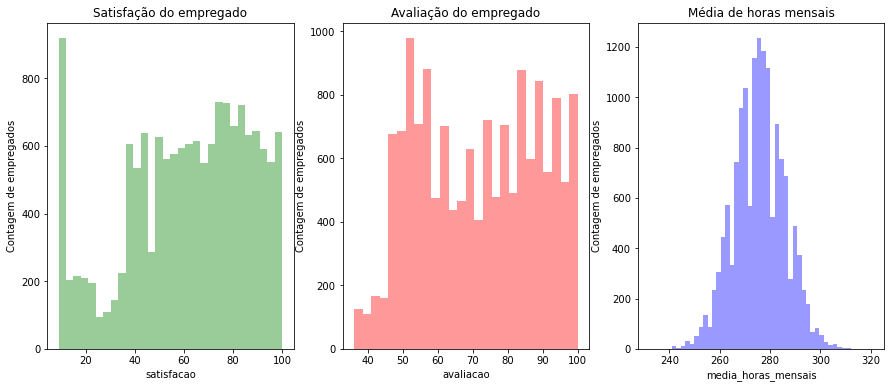

In [1685]:
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

sns.distplot(df.satisfacao, kde=False, color="g", ax=axes[0]).set_title('Satisfação do empregado')
axes[0].set_ylabel('Contagem de empregados')

sns.distplot(df.avaliacao, kde=False, color="r", ax=axes[1]).set_title('Avaliação do empregado')
axes[1].set_ylabel('Contagem de empregados')

sns.distplot(df.media_horas_mensais, kde=False, color="b", ax=axes[2]).set_title('Média de horas mensais')
axes[2].set_ylabel('Contagem de empregados')
plt.show()

 - **Satisfação** - Existe um pico de empregados com baixa satisfação mas a maior concentração está em 60 a 80.
 - **Avaliação** - Temos uma distribuição bimodal de empregados com avaliações baixas, menor que de 60 e altas, maior que 80.
 - **Media de horas mensais** - A concentração da quantidade de horas trabalhadas nos últimos 3 meses está ao redor da média em 275 horas.
 
**Questões:** 
 - Existe uma razão para o pico (abaixo de 20) de empregados insatisfeitos? 

### Analisando a rotatividade em relação ao salário

[Text(0.5, 0, 'quantidade')]

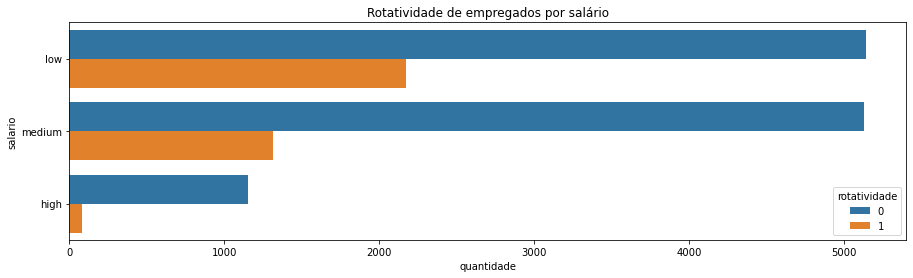

In [1686]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salario", hue='rotatividade', data=df).set_title('Rotatividade de empregados por salário')
ax.set(xlabel="quantidade")

**Resumo:** 
 - A maioria dos empregados que saíram tinha salário **baixo** ou **médio**.
 - Quase nenhum empregado com alto salário deixou a empresa.
 
**Questões:** 
 - Como é o ambiente de trabalho? Isso se difere por salário?
 - O que faz empregados com alto salário sairem da empresa.

### Analisando a rotatividade em relação ao departamento

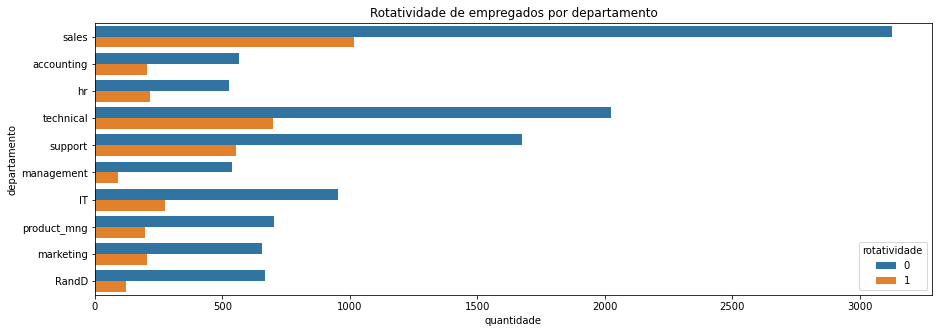

In [1687]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="departamento", hue='rotatividade', data=df).set_title('Rotatividade de empregados por departamento')
ax.set(xlabel="quantidade")
plt.show()

**Resumo:**
 - Os departamentos de vendas, técnico e suporte são top 3 departamentos com maior índice de rotatividade.
 - O departamento 'management' tem o menor volume de rotatividade.

**Questões:** 
 - Será que examinar em profundidade os departamentos que tem maior índice de rotatividade e o menor pode nos revelar mais informações importantes?
 - Qual o salário nestes departamentos?

### Analisando a rotatividade em relação ao número de projetos

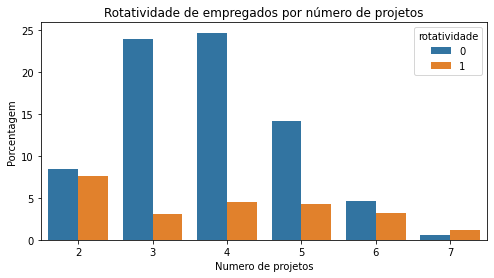

In [1688]:
fig = plt.figure(figsize=(8,4),)
ax = sns.barplot(x="num_projetos", y="num_projetos", hue="rotatividade", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Porcentagem")
ax.set(xlabel="Numero de projetos")
plt.title('Rotatividade de empregados por número de projetos')
plt.show()

**Resumo:**
 - Mais da metade dos empregados com **2, 6 e 7 projetos** deixam a empresa.
 - A maioria dos empregados que permancem na empresa estão envolvidos de **3 à 5 projetos**.
 - Todos os empregados que estavam inseridos **7 projetos** deixaram a empresa.
 - Existe uma pequena **tendência de crescimento no índice de rotatividade** em relação à quantidade de projetos.
 
**Questões:**
 - Porque os empregados estão deixando a empresa em relação a quantidade de projetos ?
 - Será que faz sentido pensar que empregados envolvidos em 2 ou menos projetos estão desmotivados e por isso deixam a empresa?
 - Será que empregados envolvidos em mais que 6 projetos se sintam sobrecarregados e deixam a empresa?

### Analisando a rotatividade em relação a avaliação do empregado

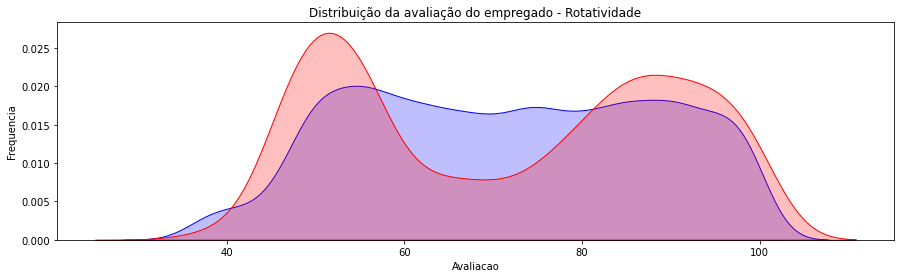

In [1689]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['rotatividade'] == 0),'avaliacao'] , color='b',shade=True, label='rotatividade negativa')
ax=sns.kdeplot(df.loc[(df['rotatividade'] == 1),'avaliacao'] , color='r',shade=True, label='rotatividade positiva')
ax.set(xlabel='Avaliacao', ylabel='Frequencia')
plt.title('Distribuição da avaliação do empregado - Rotatividade')
plt.show()

**Resumo:** 
 - Temos uma distribuição bimodal para o conjunto que deixou a empresa.
 - Colaboradores com **baixa performance** tendem a deixar a empresa.
 - Colaboradores com **alta performance** tendem a deixar a empresa.
 - O **ponto ideal** para os funcionários que permaneceram está dentro da avaliação de 60 à 80.

### Analisando a rotatividade em relação a satisfação do empregado

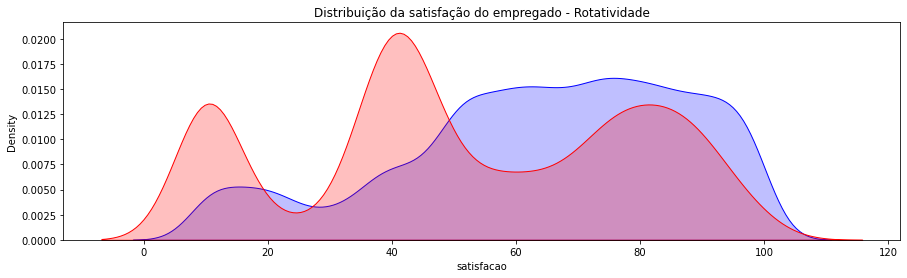

In [1690]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['rotatividade'] == 0),'satisfacao'], color='b', shade=True, label='rotatividade negativa')
ax=sns.kdeplot(df.loc[(df['rotatividade'] == 1),'satisfacao'], color='r', shade=True, label='rotatividade positiva')
plt.title('Distribuição da satisfação do empregado - Rotatividade')
plt.show()

**Resumo:** 
 - Empregados com o nível de satisfação em 20 ou menos tendem a deixar a empresa.
 - Empregados com o nível de satisfação em até 50 tem maior probabilidade de deixar a empresa.

### Analisando a rotatividade em relação ao tempo de empresa

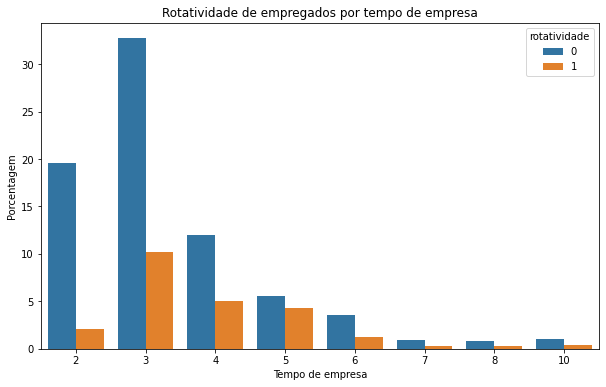

In [1691]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x="tempo_empresa", y="tempo_empresa", hue="rotatividade", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Porcentagem")
ax.set(xlabel="Tempo de empresa")
plt.title("Rotatividade de empregados por tempo de empresa")
plt.show()

**Resumo:**
 - Empregados com **4 e 5 anos de empresa** deixaram a empresa.
 - Empregados acima de **5 anos de empresa** devem ser examinados.
 
**Questões:**
  - Por que os empregados estão saindo principalmente na faixa de 3-5 anos?

### Analisando a rotatividade com a avaliação em relação a satisfação do empregado

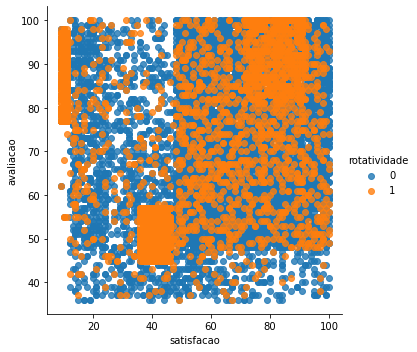

In [1692]:
sns.lmplot(x='satisfacao', y='avaliacao', data=df, fit_reg=False, hue='rotatividade')
plt.show()

**Resumo:**
 
**Grupo 1 ( Empregados insatisfeitos e trabalhadores ):** A satisfação foi inferior a 20 e as avaliações foram superiores a 75. 
- O que pode ser uma boa indicação de que os funcionários que deixaram a empresa eram bons trabalhadores, mas se sentiam péssimos no trabalho.

Questões: 
 - Qual poderia ser o motivo de se sentir tão mal quando você é altamente avaliado? 
 - Será que está trabalhando muito? 
 - Esse grupo poderia significar funcionários que estão "sobrecarregados"? 
 
**Grupo 2 ( Empregados ruins e insatisfeitos ):** Satisfação entre 35 à 50 e as suas avaliações abaixo de ~ 58. 

Questões:
- Isso pode ser visto como funcionários que foram mal avaliados e se sentiram mal no trabalho.
- Podemos chamar esse grupo de baixo desempenho?

**Grupo 3 ( Empregados satisfeitos e trabalhadores ):** Satisfação entre 75 à 90 e avaliações superiores a 80. 
- O que poderia significar que os funcionários neste grupo eram "ideais". 
- Eles amavam seu trabalho e eram altamente avaliados por seu desempenho.

Questões: 
- Este grupo pode representar os empregados que deixaram a empresa porque encontraram outra oportunidade de trabalho?
- Poderiamos ter mais do que 3 Grupos?

### Computando os grupos de empregados

In [1693]:
kmeans = KMeans(n_clusters=3, random_state=2)

In [1694]:
df_turnover = df[df.rotatividade==1][["satisfacao","avaliacao"]]

In [1695]:
kmeans.fit(df_turnover)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=2, tol=0.0001,
       verbose=0)

In [1696]:
kmeans_colors = ['blue' if c == 0 else 'green' if c == 1 else 'red' for c in kmeans.labels_]

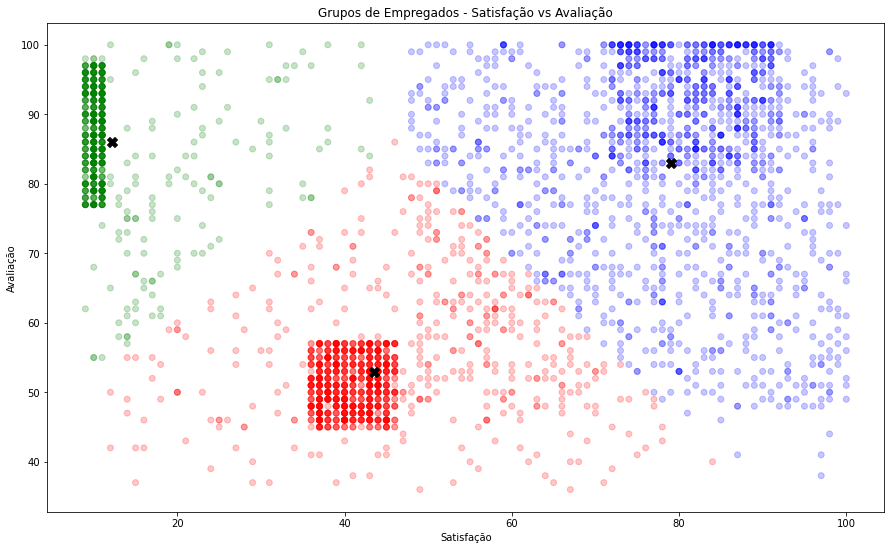

In [1697]:
fig = plt.figure(figsize=(15, 9))
plt.scatter(
  x="satisfacao",
  y="avaliacao",
  data=df_turnover,
  alpha=0.22,
  color=kmeans_colors)

plt.xlabel("Satisfação")
plt.ylabel("Avaliação")

plt.scatter(
  x=kmeans.cluster_centers_[:,0],
  y=kmeans.cluster_centers_[:,1],
  color="black",
  marker="X",
  s=100)

plt.title("Grupos de Empregados - Satisfação vs Avaliação")
plt.show()

**Grupo (Verde):** Empregados trabalhadores e satisfeitos.

**Grupo (Azul):** Empregados trabalhadores e insatisfeitos.

**Grupo (Vermelho):** Empregados ruins e insatisfeitos.

## Preparando a base para Machine Learning

In [1698]:
df.head()

,departamento,salario,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


### Converter variaveis de categorias para numero

In [1699]:
df["departamento"] = df["departamento"].astype('category').cat.codes
df["salario"] = df["salario"].astype('category').cat.codes
df.head()

,departamento,salario,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


In [1700]:
target_name = 'rotatividade'
X = df.drop(target_name, axis=1)
y = df[target_name]

### Separando os conjuntos de treino e de teste

In [1701]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.77777778, 0.5       , 0.38202247, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.77777778, 1.        , 0.2247191 , ..., 0.78125   , 0.5       ,
        0.        ],
       [0.77777778, 1.        , 0.64044944, ..., 0.8125    , 0.25      ,
        0.        ],
       ...,
       [0.88888889, 0.5       , 0.62921348, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.88888889, 0.5       , 0.4494382 , ..., 0.9375    , 0.25      ,
        0.        ],
       [0.88888889, 0.5       , 0.49438202, ..., 0.25      , 0.125     ,
        0.        ]])

In [1702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=6856, 1=2143, Test: 0=4572, 1=1428


**obs:** stratify para manter a proporção visto que a base é desbalanceada

### Treinando o algoritmo de árvore de decisão

In [1703]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, random_state=None,
                       splitter='best')

In [1704]:
importances = dtree.feature_importances_
feat_names = df.drop(['rotatividade'],axis=1).columns

### Analise de relevancia de caracteristicas para modelo de árvore de decisão

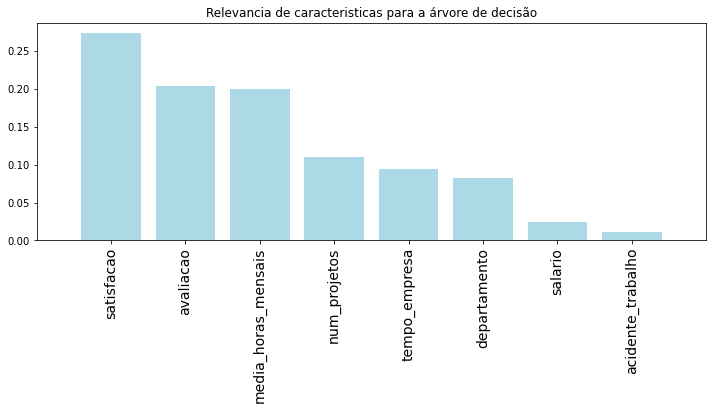

In [1705]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Relevancia de caracteristicas para a árvore de decisão")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Filtrando apenas os atributos mais relevantes

In [1706]:
X = df[["satisfacao","avaliacao","media_horas_mensais","tempo_empresa"]]
X

,satisfacao,avaliacao,media_horas_mensais,tempo_empresa
0,38.0,53.0,266,3
1,80.0,86.0,252,6
2,11.0,88.0,289,4
3,72.0,87.0,275,5
4,37.0,52.0,292,3
...,...,...,...,...
14994,40.0,57.0,287,3
14995,37.0,48.0,253,3
14996,37.0,53.0,288,3
14997,11.0,96.0,272,4


### Normalizando e separando os conjuntos de dados

In [1707]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.31868132, 0.265625  , 0.38202247, 0.125     ],
       [0.78021978, 0.78125   , 0.2247191 , 0.5       ],
       [0.02197802, 0.8125    , 0.64044944, 0.25      ],
       ...,
       [0.30769231, 0.265625  , 0.62921348, 0.125     ],
       [0.02197802, 0.9375    , 0.4494382 , 0.25      ],
       [0.30769231, 0.25      , 0.49438202, 0.125     ]])

In [1708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y)

#### Funções utilitaria para avaliação dos modelos

In [1709]:
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

In [1710]:
def accuracy_result(model,y_test,y_predict,report=False):
    acc = accuracy_score(y_test, y_predict)
    roc_ = roc_auc_score(y_test, y_predict)
    print("{}".format(model))
    print("Accuracy = %2.2f" % acc)
    print("AUC = {}".format(roc_))

    if(report):
      classfication_report = classification_report(y_test, y_predict)
      print(classfication_report)
    return acc, roc_


## Inciando a seleção do modelo de Machine Learning

### Modelo base

In [1711]:
base_predict = base_rate_model(X_test)
base_acc, base_roc = accuracy_result("Base Model", y_test, base_predict)

Base Model
Accuracy = 0.76
AUC = 0.5


### Modelo de Árvore de decisão (Decision Tree)

In [1712]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, random_state=None,
                       splitter='best')

#### Avaliação do Modelo de Árvore de decisão

In [1713]:
dtree_predict = dtree.predict(X_test)
dtree_acc, dtree_roc = accuracy_result("Decision Tree", y_test, dtree_predict)

Decision Tree
Accuracy = 0.73
AUC = 0.6380268642890228


### Modelo de Árvore Aleatória (Random Forest)

In [1714]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Avaliação do Modelo de Árvore Aleatória

In [1715]:
rf_predict = rf.predict(X_test)
rf_acc, rf_roc = accuracy_result("Random Forest", y_test, rf_predict)

Random Forest
Accuracy = 0.80
AUC = 0.6898880287022946


### Modelo de reforço de gradiente leve (Light Gradient Boosting)

In [1716]:
lgbm = LGBMClassifier()
lgbm = lgbm.fit(X_train, y_train)
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Avaliação do Modelo de Reforço de Gradiente Leve

In [1717]:
lgbm_predict = lgbm.predict(X_test)
lgbm_acc, lgbm_roc = accuracy_result("Light Gradient Boosting", y_test, lgbm_predict, report=True)

Light Gradient Boosting
Accuracy = 0.82
AUC = 0.7424329311777205
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4572
           1       0.64      0.59      0.61      1428

    accuracy                           0.82      6000
   macro avg       0.76      0.74      0.75      6000
weighted avg       0.82      0.82      0.82      6000



### Modelo de reforço de gradiente (Gradient Boosting)

In [1718]:
gbc = GradientBoostingClassifier()
gbc = gbc.fit(X_train, y_train)
gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, random_state=None,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)

#### Avaliação do Modelo de Reforço de Gradiente

In [1719]:
gbc_predict = gbc.predict(X_test)
gbc_acc, gbc_roc = accuracy_result("Gradient Boosting", y_test, gbc_predict, report=True)

Gradient Boosting
Accuracy = 0.82
AUC = 0.7389747237477668
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4572
           1       0.65      0.58      0.61      1428

    accuracy                           0.82      6000
   macro avg       0.76      0.74      0.75      6000
weighted avg       0.82      0.82      0.82      6000



## Aprimorando hyper parametros dos melhores modelos

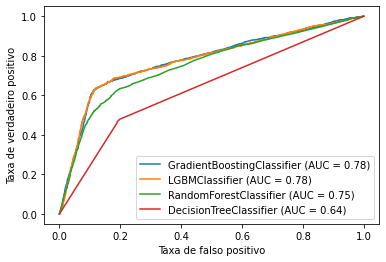

In [1720]:
select_auc_chart = plot_roc_curve(gbc, X_test,y_test)
plot_roc_curve(lgbm, X_test,y_test, ax=select_auc_chart.ax_)
plot_roc_curve(rf, X_test,y_test, ax=select_auc_chart.ax_)
plot_roc_curve(dtree, X_test,y_test, ax=select_auc_chart.ax_)
plt.ylabel('Taxa de verdadeiro positivo')
plt.xlabel('Taxa de falso positivo')
plt.show()

### Aprimorando parametros do modelo Gradient Boosting Classifier

In [1721]:
tuned_gbc = GradientBoostingClassifier(
  learning_rate=0.01,
  max_depth=4,
  max_features=1.0,
  min_impurity_decrease=0.001,
  min_samples_leaf=5,
  min_samples_split=9,
  n_estimators=300,
  random_state=123)
tuned_gbc = tuned_gbc.fit(X_train, y_train)
tuned_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.001, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=9,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, random_state=123,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)

In [1722]:
gbc_acc, gbc_roc = accuracy_result("Gradient Boosting Base", y_test, gbc_predict, report=True)

Gradient Boosting Base
Accuracy = 0.82
AUC = 0.7389747237477668
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4572
           1       0.65      0.58      0.61      1428

    accuracy                           0.82      6000
   macro avg       0.76      0.74      0.75      6000
weighted avg       0.82      0.82      0.82      6000



In [1723]:
tuned_gbc_predict = tuned_gbc.predict(X_test)
tuned_gbc_acc, tuned_gbc_roc = accuracy_result("Gradient Boosting Aprimorado", y_test, tuned_gbc_predict, report=True)

Gradient Boosting Aprimorado
Accuracy = 0.83
AUC = 0.7429135696273261
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4572
           1       0.65      0.58      0.62      1428

    accuracy                           0.83      6000
   macro avg       0.76      0.74      0.75      6000
weighted avg       0.82      0.83      0.82      6000



### Aprimorando parametros do modelo LGBMClassifier

In [1724]:
tuned_lgbm = LGBMClassifier(
  learning_rate=0.3,
  min_child_samples=11,
  min_split_gain=0.6,
  n_estimators=240,
  num_leaves=6,
  reg_alpha=0.1,
  reg_lambda=0.1,
)
tuned_lgbm = tuned_lgbm.fit(X_train, y_train)
tuned_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=11, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=240, n_jobs=-1, num_leaves=6, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [1725]:
lgbm_acc, lgbm_roc = accuracy_result("LGBMClassifier Base", y_test, lgbm_predict, report=True)

LGBMClassifier Base
Accuracy = 0.82
AUC = 0.7424329311777205
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4572
           1       0.64      0.59      0.61      1428

    accuracy                           0.82      6000
   macro avg       0.76      0.74      0.75      6000
weighted avg       0.82      0.82      0.82      6000



In [1726]:
tuned_lgbm_predict = tuned_lgbm.predict(X_test)
tuned_lgbm_acc, tuned_lgbm_roc = accuracy_result("LGBMClassifier Aprimorado", y_test, tuned_lgbm_predict, report=True)

LGBMClassifier Aprimorado
Accuracy = 0.83
AUC = 0.75083721152503
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4572
           1       0.64      0.61      0.62      1428

    accuracy                           0.83      6000
   macro avg       0.76      0.75      0.76      6000
weighted avg       0.82      0.83      0.82      6000



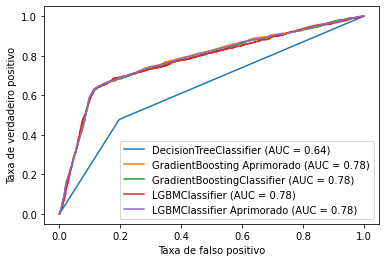

In [1742]:
compare_auc_chart = plot_roc_curve(dtree, X_test,y_test)
plot_roc_curve(tuned_gbc, X_test,y_test,ax=compare_auc_chart.ax_, name='GradientBoosting Aprimorado')
plot_roc_curve(gbc, X_test,y_test, ax=compare_auc_chart.ax_)
plot_roc_curve(lgbm, X_test,y_test, ax=compare_auc_chart.ax_)
plot_roc_curve(tuned_lgbm, X_test,y_test, ax=compare_auc_chart.ax_,name='LGBMClassifier Aprimorado')
plt.ylabel('Taxa de verdadeiro positivo')
plt.xlabel('Taxa de falso positivo')
plt.show()

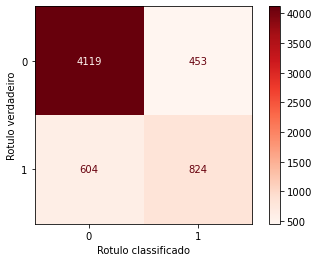

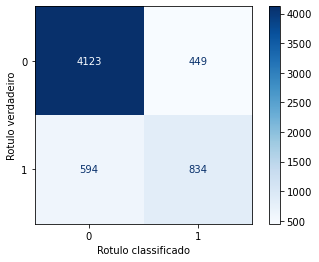

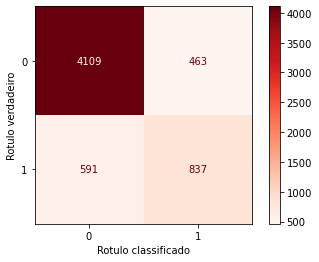

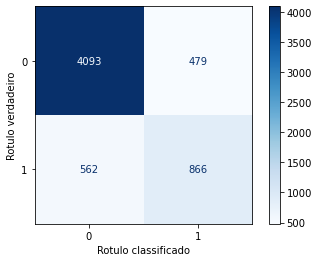

In [1743]:
gbc_matrix_chart = plot_confusion_matrix(gbc, X_test, y_test, cmap='Reds')
plt.ylabel('Rotulo verdadeiro')
plt.xlabel('Rotulo classificado')

tuned_gbc_matrix_chart = plot_confusion_matrix(tuned_gbc, X_test, y_test, cmap='Blues')
plt.ylabel('Rotulo verdadeiro')
plt.xlabel('Rotulo classificado')

lgbm_matrix_chart = plot_confusion_matrix(lgbm, X_test, y_test, cmap='Reds')
plt.ylabel('Rotulo verdadeiro')
plt.xlabel('Rotulo classificado')

tuned_lgbm_matrix_chart = plot_confusion_matrix(tuned_lgbm, X_test, y_test, cmap='Blues')
plt.ylabel('Rotulo verdadeiro')
plt.xlabel('Rotulo classificado')

plt.show()

## Usando o melhor modelo com novas entradas

#### Metodos utilitários

In [1729]:
def get_dataframe_averages(
  satisfacao = df.satisfacao.mean(),
  avaliacao = df.avaliacao.mean(),
  media_horas_mensais = df.media_horas_mensais.mean(),
  tempo_empresa = df.tempo_empresa.mean()):
    print("Médias dos dados analisados")
    print("Satisfação = %2.2f" % satisfacao)
    print("avaliacao = %2.2f" % avaliacao)
    print("Horas mensais = %2.2f" % media_horas_mensais)
    print("Tempo de empresa = %2.2f" % tempo_empresa)
    return satisfacao,avaliacao,media_horas_mensais,tempo_empresa

In [1730]:
def normalize_new_input(value=0 , feature = 'avaliacao'):
    feature_max = df[feature].max()
    feature_min = df[feature].min()
    scale = (1 - 0) / (feature_max - feature_min)
    scaled_value  = scale * value + 0 - feature_min * scale
    return scaled_value

### Adicionando uma entrada de dados

In [1731]:
df.head()

,departamento,salario,media_horas_mensais,num_projetos,satisfacao,avaliacao,tempo_empresa,acidente_trabalho,rotatividade
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


In [1732]:
satisfacao,avaliacao,media_horas_mensais,tempo_empresa = get_dataframe_averages()

Médias dos dados analisados
Satisfação = 61.28
avaliacao = 71.61
Horas mensais = 275.69
Tempo de empresa = 3.50


In [1733]:
# Nova entrada de dados
satisfacao = 69
avaliacao = 85
media_horas_mensais = 280
tempo_empresa = 3

In [1734]:
new_entry_normalized = pd.DataFrame()
new_entry_normalized["satisfacao"] = [normalize_new_input(satisfacao,'satisfacao')]
new_entry_normalized["avaliacao"] =	[normalize_new_input(avaliacao, "avaliacao")]
new_entry_normalized["media_horas_mensais"] = [normalize_new_input(media_horas_mensais,'media_horas_mensais')]
new_entry_normalized["tempo_empresa"] = [normalize_new_input(tempo_empresa,'tempo_empresa')]
new_entry_normalized

,satisfacao,avaliacao,media_horas_mensais,tempo_empresa
0,0.659341,0.765625,0.539326,0.125


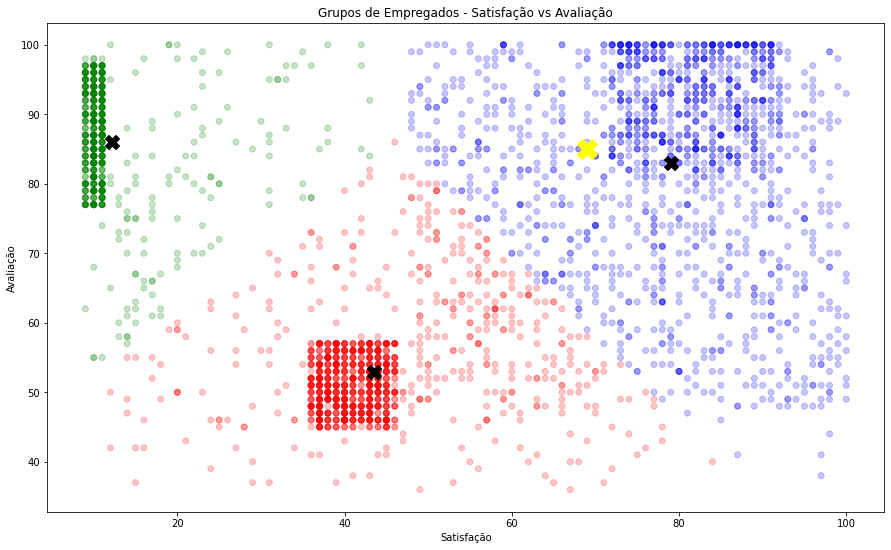

In [1735]:
plt.figure(figsize=(15, 9))
plt.scatter( 
  x="satisfacao",
  y="avaliacao",
  data=df[df.rotatividade==1],
  alpha=0.22,
  color=kmeans_colors)

plt.xlabel("Satisfação")
plt.ylabel("Avaliação")

plt.scatter( 
  x=kmeans.cluster_centers_[:,0],
  y=kmeans.cluster_centers_[:,1],
  color="black",
  marker="X",
  s=200)

plt.scatter( 
  x=[satisfacao],
  y=[avaliacao],
  color="yellow",
  marker="X",
  s=400)

plt.title("Grupos de Empregados - Satisfação vs Avaliação")
plt.show()

**Grupo (Verde):** Empregados trabalhadores e satisfeitos.

**Grupo (Azul):** Empregados trabalhadores e insatisfeitos.

**Grupo (Vermelho):** Empregados ruins e insatisfeitos.

In [1736]:
print('Predição de rotatividade: {}'.format(tuned_lgbm.predict(new_entry_normalized)[0]))
print("probabilidade de ficar na empresa = %2.3f" % tuned_lgbm.predict_proba(new_entry_normalized)[0][0])
print("probabilidade de sair da empresa = %2.3f" % tuned_lgbm.predict_proba(new_entry_normalized)[0][1])

Predição de rotatividade: 0
probabilidade de ficar na empresa = 0.881
probabilidade de sair da empresa = 0.119


## Fim